# Basic Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Dataset

In [ ]:
customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eCommerce files/Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eCommerce files/Transactions.csv')

# Data Preprocessing

In [ ]:
# Merge data
transactions_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'TransactionID': 'count'
}).reset_index()
transactions_summary.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'TransactionCount']

customers['DaysSinceSignup'] = (pd.Timestamp.now() - pd.to_datetime(customers['SignupDate'])).dt.days
customers = customers.merge(transactions_summary, on='CustomerID', how='left').fillna(0)

In [ ]:
# One-hot encode categorical data
customers_encoded = pd.get_dummies(customers, columns=['Region'], drop_first=True)

# Drop unnecessary columns
X = customers_encoded.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering and Metrics for Kmeans

Clusters: 2, DBI: 1.9771, Silhouette: 0.1786
Clusters: 3, DBI: 1.6317, Silhouette: 0.2355
Clusters: 4, DBI: 1.4014, Silhouette: 0.2680
Clusters: 5, DBI: 1.3204, Silhouette: 0.2573
Clusters: 6, DBI: 1.3070, Silhouette: 0.2488
Clusters: 7, DBI: 1.3250, Silhouette: 0.2386
Clusters: 8, DBI: 1.3615, Silhouette: 0.2405
Clusters: 9, DBI: 1.3190, Silhouette: 0.2462
Clusters: 10, DBI: 1.3149, Silhouette: 0.2361


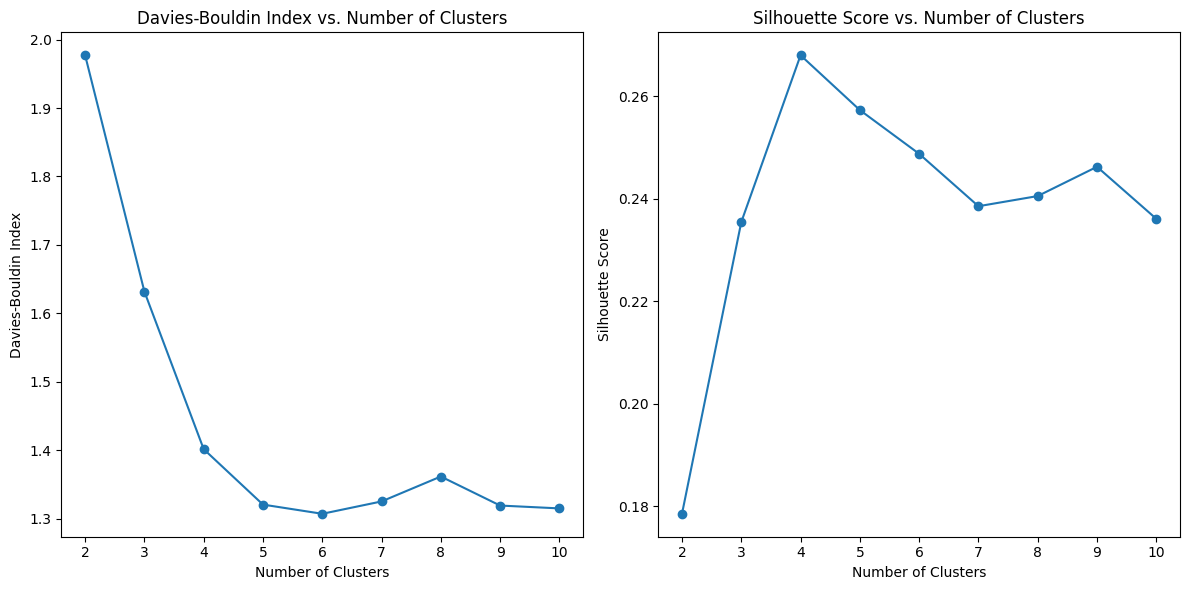

Optimal number of clusters based on DBI: 6
Optimal number of clusters based on Silhouette Score: 4


In [ ]:
# Function to find the optimal number of clusters
def find_optimal_clusters(data, min_clusters=2, max_clusters=10):
    dbi_scores = []
    silhouette_scores = []
    cluster_range = range(min_clusters, max_clusters + 1)

    for n_clusters in cluster_range:
        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate Davies-Bouldin Index
        dbi = davies_bouldin_score(data, cluster_labels)
        dbi_scores.append(dbi)

        # Calculate Silhouette Score
        sil_score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(sil_score)

        print(f"Clusters: {n_clusters}, DBI: {dbi:.4f}, Silhouette: {sil_score:.4f}")

    # Find the optimal number of clusters based on the lowest DBI and highest Silhouette Score
    optimal_clusters_dbi = cluster_range[dbi_scores.index(min(dbi_scores))]
    optimal_clusters_sil = cluster_range[silhouette_scores.index(max(silhouette_scores))]

    # Plot results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, dbi_scores, marker='o')
    plt.title('Davies-Bouldin Index vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')

    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return optimal_clusters_dbi, optimal_clusters_sil

# Usage example
optimal_dbi, optimal_sil = find_optimal_clusters(X_scaled, min_clusters=2, max_clusters=10)

print(f"Optimal number of clusters based on DBI: {optimal_dbi}")
print(f"Optimal number of clusters based on Silhouette Score: {optimal_sil}")

In [ ]:
# Apply KMeans clustering with 4 centroids
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
customers['Cluster'] = clusters

In [ ]:
# Calculate Davies-Bouldin Index and Silhouette Score
db_index = davies_bouldin_score(X_scaled, clusters)
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Kmeans Davies-Bouldin Index: {db_index}")
print(f"Kmeans Silhouette Score: {silhouette_avg}")

Kmeans Davies-Bouldin Index: 1.4014431450559188
Kmeans Silhouette Score: 0.267997077186446


# Visualization of KMeans

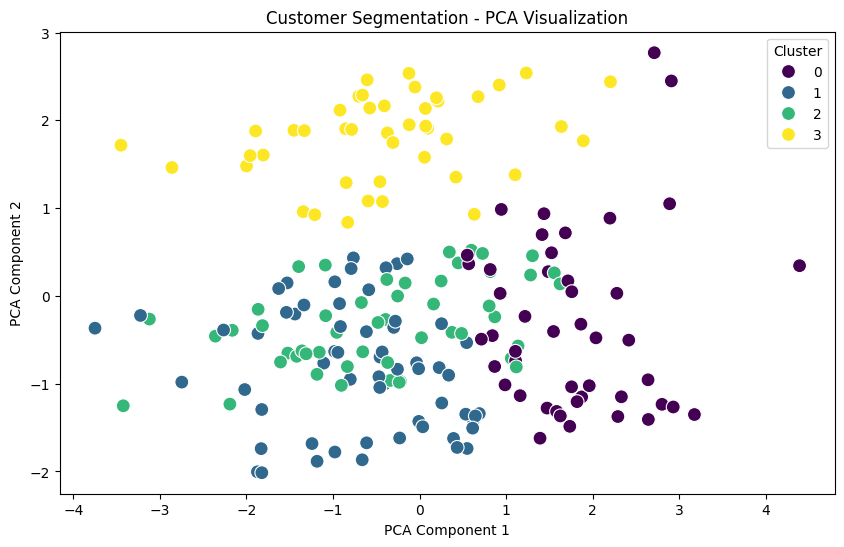

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=customers['Cluster'], palette='viridis', s=100)
plt.title('Customer Segmentation - PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Clustering and Metrics for Agglomerative Clustering

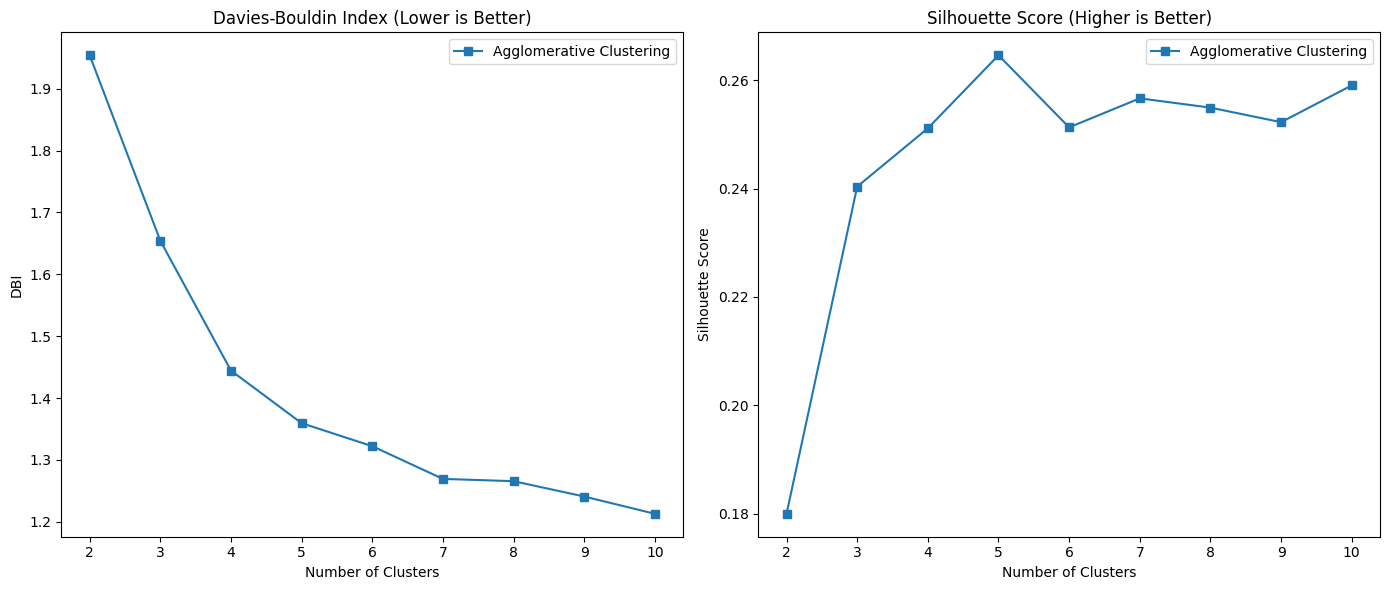

Best number of clusters for Agglomerative Clustering based on DBI: 10
Best number of clusters for Agglomerative Clustering based on Silhouette Score: 5


In [ ]:
# Initialize empty lists to store the scores for each cluster number
dbi_agg_scores = []
silhouette_agg_scores = []

# Loop over a range of cluster numbers (2 to 10)
for n_clusters in range(2, 11):
    # Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean')
    agg_labels = agg.fit_predict(X_scaled)

    # Calculate DBI and Silhouette Score for Agglomerative Clustering
    dbi_agg_scores.append(davies_bouldin_score(X_scaled, agg_labels))
    silhouette_agg_scores.append(silhouette_score(X_scaled, agg_labels))

# Plot the DBI and Silhouette Scores for GMM and Agglomerative Clustering
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot DBI for GMM and Agglomerative Clustering
axes[0].plot(range(2, 11), dbi_agg_scores, label='Agglomerative Clustering', marker='s')
axes[0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('DBI')
axes[0].legend()

# Plot Silhouette Score for GMM and Agglomerative Clustering
axes[1].plot(range(2, 11), silhouette_agg_scores, label='Agglomerative Clustering', marker='s')
axes[1].set_title('Silhouette Score (Higher is Better)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend()

plt.tight_layout()
plt.show()

# Find the best number of clusters based on DBI and Silhouette Score
best_n_clusters_agg = range(2, 11)[dbi_agg_scores.index(min(dbi_agg_scores))]
best_silhouette_n_clusters_agg = range(2, 11)[silhouette_agg_scores.index(max(silhouette_agg_scores))]

print(f"Best number of clusters for Agglomerative Clustering based on DBI: {best_n_clusters_agg}")
print(f"Best number of clusters for Agglomerative Clustering based on Silhouette Score: {best_silhouette_n_clusters_agg}")

In [ ]:
# Apply Agglomerative Clustering for 5 centroids
agg_clustering = AgglomerativeClustering(n_clusters=5, metric='euclidean')
customers['Cluster_Agg'] = agg_clustering.fit_predict(X_scaled)

In [ ]:
# Calculate Davies-Bouldin Index and Silhouette Score
dbi_agg = davies_bouldin_score(X_scaled, customers['Cluster_Agg'])
sil_score_agg = silhouette_score(X_scaled, customers['Cluster_Agg'])

print(f"Agglomerative Clustering Davies-Bouldin Index: {dbi_agg}")
print(f"Agglomerative Clustering Silhouette Score: {sil_score_agg}")

Agglomerative Clustering Davies-Bouldin Index: 1.3593420504544027
Agglomerative Clustering Silhouette Score: 0.2645927142955193


# Visualization of AgglomerativeClustering

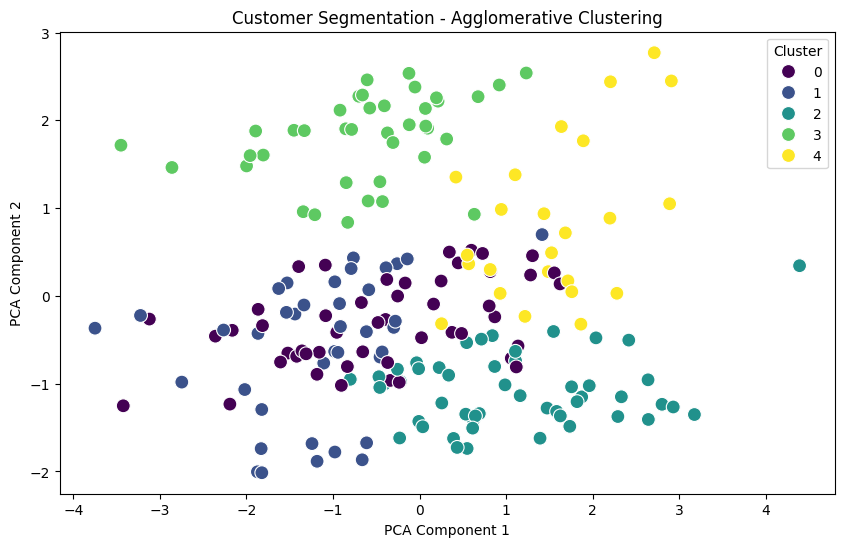

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca_agg = pca.fit_transform(X_scaled)

# Plot Agglomerative Clustering clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_agg[:, 0], y=X_pca_agg[:, 1], hue=customers['Cluster_Agg'], palette='viridis', s=100)
plt.title('Customer Segmentation - Agglomerative Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Clustering and Metrics for GMM

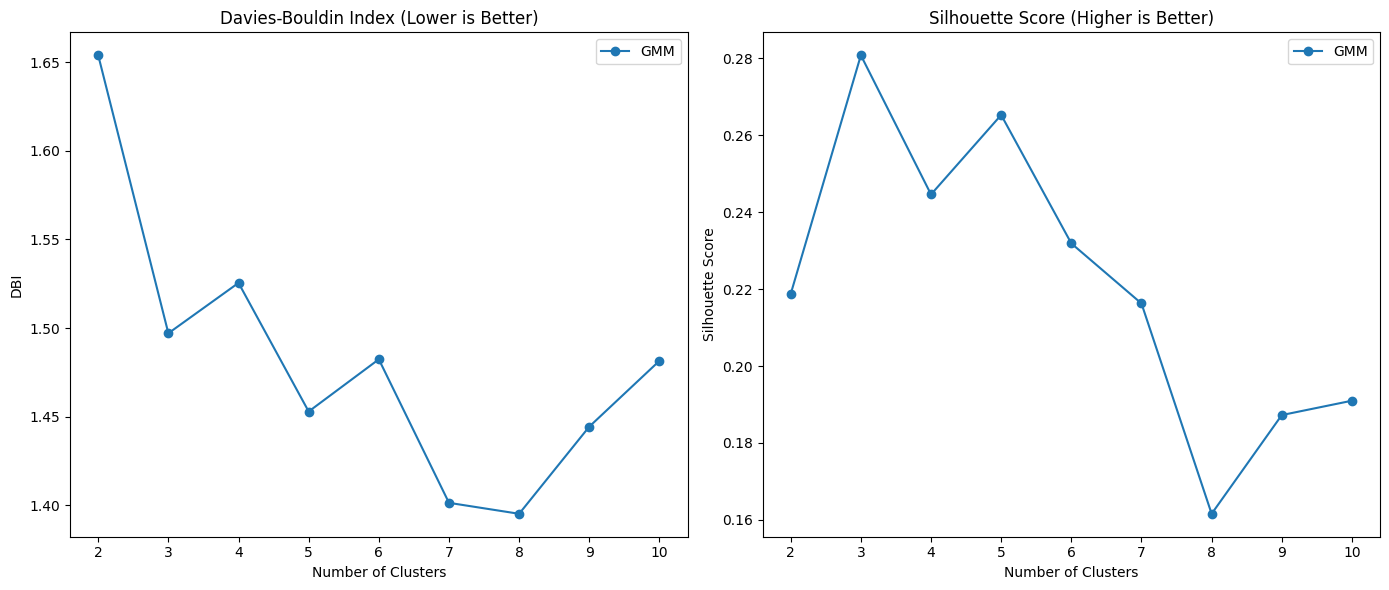

Best number of clusters for GMM based on DBI: 8
Best number of clusters for GMM based on Silhouette Score: 3


In [ ]:
dbi_gmm_scores = []
silhouette_gmm_scores = []

# Loop over a range of cluster numbers (2 to 10)
for n_clusters in range(2, 11):

    # Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)

    # Calculate DBI and Silhouette Score for GMM
    dbi_gmm_scores.append(davies_bouldin_score(X_scaled, gmm_labels))
    silhouette_gmm_scores.append(silhouette_score(X_scaled, gmm_labels))

# Plot the DBI and Silhouette Scores for GMM and Agglomerative Clustering
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot DBI for GMM and Agglomerative Clustering
axes[0].plot(range(2, 11), dbi_gmm_scores, label='GMM', marker='o')
axes[0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('DBI')
axes[0].legend()

# Plot Silhouette Score for GMM and Agglomerative Clustering
axes[1].plot(range(2, 11), silhouette_gmm_scores, label='GMM', marker='o')
axes[1].set_title('Silhouette Score (Higher is Better)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend()

plt.tight_layout()
plt.show()

# Find the best number of clusters based on DBI and Silhouette Score
best_n_clusters_gmm = range(2, 11)[dbi_gmm_scores.index(min(dbi_gmm_scores))]

best_silhouette_n_clusters_gmm = range(2, 11)[silhouette_gmm_scores.index(max(silhouette_gmm_scores))]

print(f"Best number of clusters for GMM based on DBI: {best_n_clusters_gmm}")
print(f"Best number of clusters for GMM based on Silhouette Score: {best_silhouette_n_clusters_gmm}")

In [ ]:
# Apply Gaussian Mixture Model (GMM) with 3 centriods
gmm = GaussianMixture(n_components=3, random_state=42)  # Set the number of clusters
customers['Cluster_GMM'] = gmm.fit_predict(X_scaled)

In [ ]:
# Calculate Davies-Bouldin Index and Silhouette Score
dbi_gmm = davies_bouldin_score(X_scaled, customers['Cluster_GMM'])
sil_score_gmm = silhouette_score(X_scaled, customers['Cluster_GMM'])

print(f"GMM Davies-Bouldin Index: {dbi_gmm}")
print(f"GMM Silhouette Score: {sil_score_gmm}")

GMM Davies-Bouldin Index: 1.4970558081000647
GMM Silhouette Score: 0.2808348007868954


# Visualization of GMM

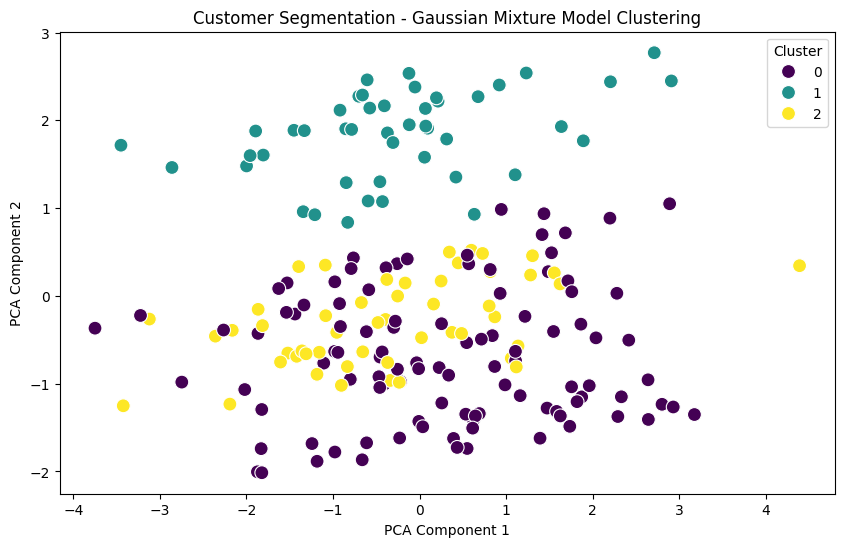

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca_gmm = pca.fit_transform(X_scaled)

# Plot GMM clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_gmm[:, 0], y=X_pca_gmm[:, 1], hue=customers['Cluster_GMM'], palette='viridis', s=100)
plt.title('Customer Segmentation - Gaussian Mixture Model Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

We performed customer segmentation using KMeans, Agglomerative Clustering, and Gaussian Mixture Model (GMM), and evaluates them using Davies-Bouldin Index (DBI) and Silhouette Score, there's no single "best" model.  The optimal model depends on the specific priorities and interpretation of the evaluation metrics.

**Summary of Model Performance:**

We evaluated each clustering algorithm across a range of cluster numbers (2-10), plotting DBI and Silhouette scores to identify potential optimal cluster numbers.  Then we applied each clustering method with a specific number of clusters (decided either by the metrics, or arbitrarily set). Finally, we calculated DBI and Silhouette scores for the selected number of clusters for each algorithm.

* **KMeans:**  4 clusters.

* **Agglomerative Clustering:** 5 clusters.
* **GMM:**  3 clusters.

 The visualization helps understand the separation of clusters in 2D space.  Evaluated its DBI and Silhouette scores to judge the quality of the clusters against the other models.

**Choosing the Best Model:**

1. **Lower DBI is better:** A lower DBI indicates better-separated clusters. Compare the DBI scores of the three models *after* they have been run with their respective "optimal" cluster counts.

2. **Higher Silhouette Score is better:** A higher Silhouette Score signifies that data points are well-matched to their own clusters and poorly matched to neighboring clusters. Compare the Silhouette Scores of the three models in the same way as above.

3. **Visual Inspection:**  The PCA visualizations provide a 2D representation of the clusters.  Observe if the clusters appear well-separated and distinct in each model's visualization.  A model with visually distinct and well-separated clusters is generally preferred.

4. **Domain Knowledge:**  The "best" model might also depend on business context or domain expertise.  For example, if a certain number of customer segments are already expected, or if prior knowledge indicates certain customer groups are likely to exist, the results should be reviewed in this light.

# Best Model: Agglomerative Clustering

Reasoning: Although GMM has the highest silhouette score (0.28), Agglomerative Clustering has the lowest Davies-Bouldin Index (1.36), indicating better cluster separation compared to GMM (1.50) and KMeans (1.40).

Trade-off: While the silhouette score is slightly lower for Agglomerative Clustering, its superior DBI suggests better cluster cohesion and separation overall.

# END